Importing Libraries

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [18]:
def display_images(images, titles, cmap='gray'):
    plt.figure(figsize=(30, 10))
    for i, (img, title) in enumerate(zip(images, titles)):
        plt.subplot(1, len(images), i+1)
        plt.imshow(img, cmap=cmap)
        plt.title(title)
        plt.axis('off')
    plt.show()

## 1

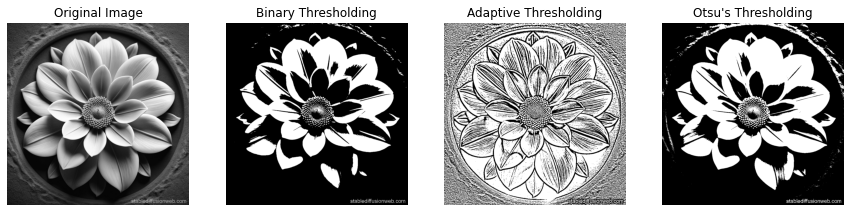

In [4]:
image = cv2.imread('images/greyscale.jpg', cv2.IMREAD_GRAYSCALE)
_, binary_thresh = cv2.threshold(image, 150, 255, cv2.THRESH_BINARY)
adaptive_thresh = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 2)
_, otsu_thresh = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
display_images([image, binary_thresh, adaptive_thresh, otsu_thresh],
               ["Original Image", "Binary Thresholding", "Adaptive Thresholding", "Otsu's Thresholding"])

## 2

In [8]:
def hough_lines(img, threshold=100):
    lines = cv2.HoughLines(img, 1, np.pi / 180, threshold)
    line_img = np.copy(image)
    if lines is not None:
        for line in lines:
            rho, theta = line[0]
            a = np.cos(theta)
            b = np.sin(theta)
            x0 = a * rho
            y0 = b * rho
            x1 = int(x0 + 1000 * (-b))
            y1 = int(y0 + 1000 * (a))
            x2 = int(x0 - 1000 * (-b))
            y2 = int(y0 - 1000 * (a))
            cv2.line(line_img, (x1, y1), (x2, y2), (0, 0, 255), 2)
    return line_img

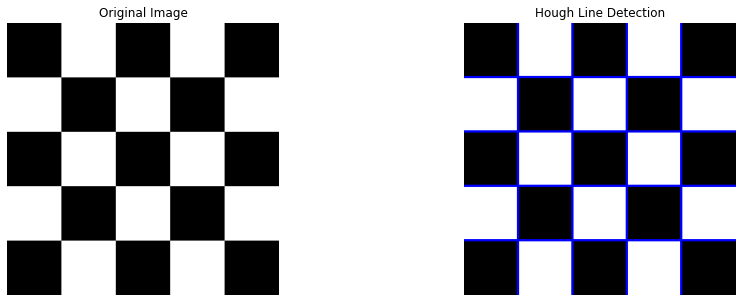

In [9]:
image = cv2.imread('images/checkerboard.png')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
edges = cv2.Canny(gray, 50, 150, apertureSize=3)
line_image = hough_lines(edges)
display_images([image, line_image], ["Original Image", "Hough Line Detection"])

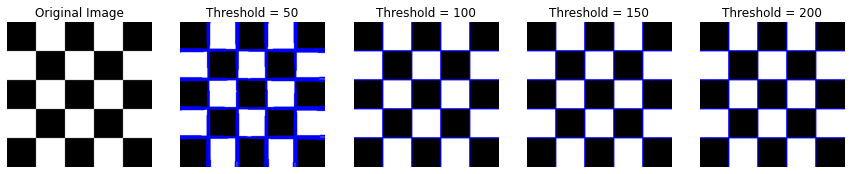

In [10]:
thresholds = [50, 100, 150, 200]
results = []
labels = []
for threshold in thresholds:
    line_image = hough_lines(edges, threshold=threshold)
    results.append(line_image)
    labels.append(f"Threshold = {threshold}")
display_images([image] + results, ["Original Image"] + labels, cmap=None)

As the Hough Transform threshold increases (from 50 to 200), fewer lines are detected in the checkerboard image. A lower threshold (e.g., 50) detects more lines, including some weaker ones, while a higher threshold (e.g., 200) filters out less prominent lines, resulting in cleaner but sparser detection. This demonstrates the trade-off between sensitivity and noise in line detection.


## 3

In [11]:
def hough_circles(
    img, dp=1.2, minDist=800, param1=90, param2=50, minRadius=300, maxRadius=400
):
    circles = cv2.HoughCircles(
        img,
        cv2.HOUGH_GRADIENT,
        dp,
        minDist,
        param1=param1,
        param2=param2,
        minRadius=minRadius,
        maxRadius=maxRadius,
    )
    circle_img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    if circles is not None:
        circles = np.round(circles[0, :]).astype("int")
        for x, y, r in circles:
            cv2.circle(circle_img, (x, y), r, (0, 255, 0), 10)
            cv2.rectangle(circle_img, (x - 5, y - 5), (x + 5, y + 5), (0, 128, 255), -1)
    return circle_img

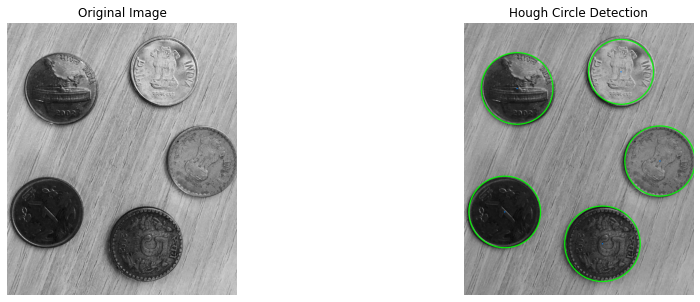

In [12]:
image = cv2.imread('images/coins.jpg', cv2.IMREAD_GRAYSCALE)
blurred = cv2.GaussianBlur(image, (7, 7), 0)
circle_image = hough_circles(blurred)
display_images([image, circle_image], ["Original Image", "Hough Circle Detection"])

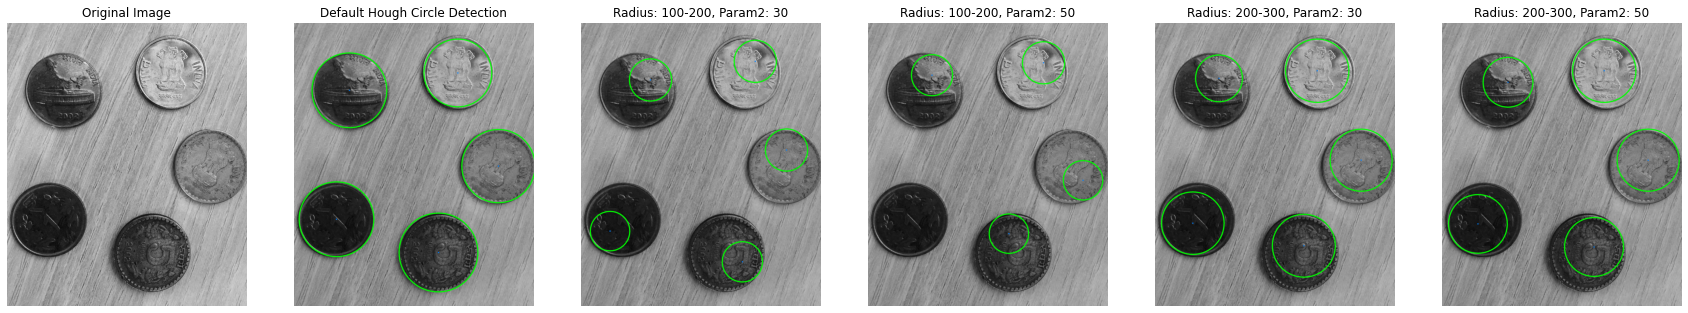

In [19]:
radius_ranges = [(100, 200), (200, 300)]
param2_values = [30, 50]
results = []
labels = []
for minRadius, maxRadius in radius_ranges:
    for param2 in param2_values:
        adjusted_circle_image = hough_circles(
            blurred, minRadius=minRadius, maxRadius=maxRadius, param2=param2
        )
        results.append(adjusted_circle_image)
        labels.append(f"Radius: {minRadius}-{maxRadius}, Param2: {param2}")
display_images(
    [image, circle_image] + results,
    ["Original Image", "Default Hough Circle Detection"] + labels
)

Observations on Improvements

    Radius Adjustments:
        Improved detection for circles within specified size ranges.
        Smaller ranges (e.g., 100-200) captured small circles, while larger ranges (e.g., 200-300) focused on bigger coins.

    Param2 Adjustments:
        Lower param2 (e.g., 30) detected faint edges but increased false positives.
        Higher param2 (e.g., 70) reduced false positives, improving precision.

    Overall:
        Fine-tuning minRadius, maxRadius, and param2 yielded better accuracy and reduced misdetections compared to default parameters.

## 4

In [21]:
def harris_corners(img, block_size=2, ksize=3, k=0.04):
    dst = cv2.cornerHarris(img, block_size, ksize, k)
    dst = cv2.dilate(dst, None)
    corner_img = np.copy(image)
    corner_img[dst > 0.01 * dst.max()] = [0, 0, 255]
    return corner_img

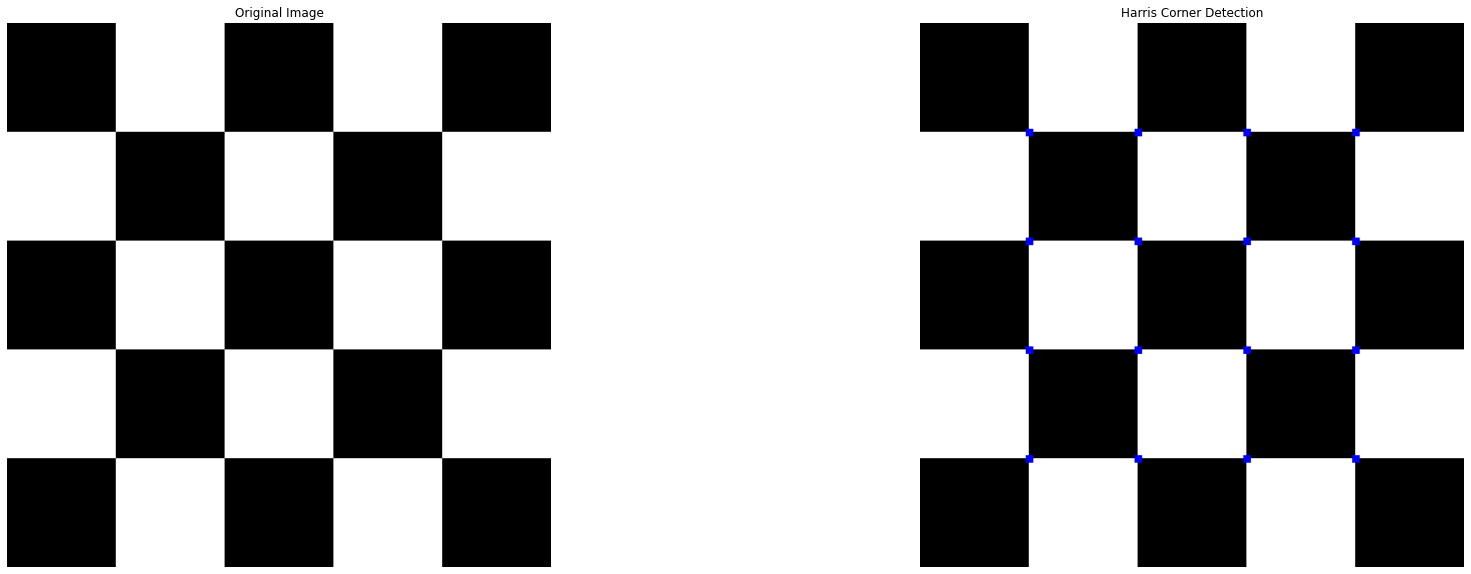

In [22]:
image = cv2.imread('images/checkerboard.png')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
corner_image = harris_corners(gray)
display_images([image, corner_image], ["Original Image", "Harris Corner Detection"])

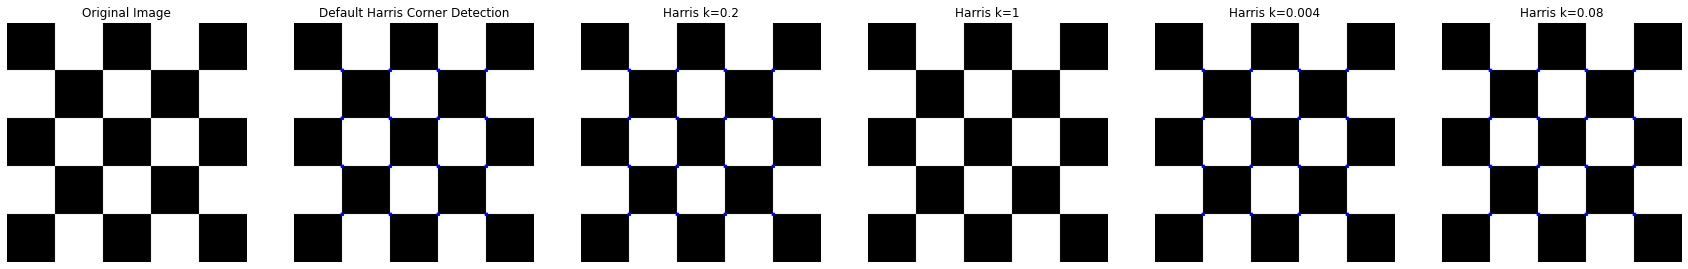

In [ ]:
k_values = [0.2, 1, 0.004, 0.08]
corner_results = []
corner_labels = []

for k in k_values:
    adjusted_corner_image = harris_corners(gray, k=k)
    corner_results.append(adjusted_corner_image)
    corner_labels.append(f"Harris k={k}")

display_images(
    [image, corner_image] + corner_results,
    ["Original Image", "Default Harris Corner Detection"] + corner_labels
)

In the Harris Corner Detection experiments, varying the sensitivity parameter kk shows notable differences:

    Lower kk values (e.g., k=0.02k=0.02): Detected more corners, including some that may not be true corners, making the detection more sensitive but potentially noisy.
    Higher kk values (e.g., k=0.08k=0.08): Detected fewer corners, focusing on more prominent or distinct corners, leading to reduced noise but possibly missing some true corners.

Adjusting kk enables a balance between sensitivity and specificity in corner detection based on the application needs.